# Building an OCR from scratch

So in this tutorial, I will give you a basic code walkthrough for building a simple OCR. OCR as might know stands for optical character recognition or in layman terms it means text recognition. Text recognition is one of the classic problems in computer vision and is still relevant today. One of the most important applications of text recognition is the digitization of old manuscripts. Physical copies of books and manuscripts are prone to degradations. With time, the printed characters start to fade. On simple way to preserve such documents is to make a digital copy of it and store it in the cloud or local hard drive which would ensure their continuance. Similarly, text recognition can also be used for licence plate recognition and can also be used in forensics in terms of handwriting recognition. 

Okay, now that I have given you enough motivation as to why OCR is important, let me show you how you can build one. 
So first things first, I'll start with listing down some of the essential packages that you would need to build your first OCR. We will be working with PyTorch as it is one of the most efficient deep learning libraries present. The other packages are as follows:

* Pytorch 1.5
* Matplotlib
* Tqdm
* textdistance
* lmdb

You can install them either via a pip or conda. I will also be providing a requirements.txt file which you can find in my Github repo. Do a simple `pip install -r requirements` and you are set to go.

## Setting up the Data

We will start our project by importing the libraries. But before that we need data. Now, you are free to use any text image data you might like and for that, you might need to build your own data loader. However, in the interest of keeping things simple, we will be using a neat little package called `trdg`, which is a synthetic image generator for OCR. You can find all the relevant information regarding this package on its [github repository](https://github.com/Belval/TextRecognitionDataGenerator). You can generate printed as well as hand-written text images and infuse them with different kinds of noise and degradation. In this project, I have used trdg to generate printed word images of a single font. You can use any font you like. Just download a `.ttf` file for your font and while generating the word images be sure to specify the `-ft` parameter as your font file. 

You can generate the word images for training using the following commands:

`trdg -i words.txt -c 20000 --output_dir data/train -ft your/fontfile`

Here, `-c` refers to the number of word images you want to generate. `words.txt` file contains our input word vocabulary while `--output_dir` and `-ft` refer to the output and font file respectively. You can similarly generate the test word images for evaluating the performance of your OCR. However, ensure that words for training and testing are mutually exclusive to each other.


Okay, now that we have generated the word images, let us display a few images using matlplotlib
%# TODO diplay images from folder

Now lets start importing the libraries that we would need to build our OCR

In [1]:
import os
import sys
import pdb
import six
import random
# import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
import xml.etree.ElementTree as ET



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
# from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *


Next, let us create our data pipe-line. We do this by inheriting the PyTorch Dataset class. The Dataset class has few methods that we need to adhere to like the `__len__` and `__getitem__` method. The `__len__` method returns the number of items in our dataset while `__getitem_` returns the data item for the index passed. You can find more information on PyTorch Dataset class on PyTorch's official documentation page. 

You will observe that we first convert each image into grayscale and convert it into a tensor. This is followed by normalizing the images so that our input data lies within a range of [-1, 1]. We pass all such transformations into a list and later call the transforms to compose function provided by PyTorch. The transform Compose function applies each transformation in the pre-defined order.

In [2]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.xmldir = os.path.join(opt['path'], opt['XMLdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                            transforms.Resize((opt['imgH'], opt['imgW'])),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples
    
    def get_label(self, index):
        imagepath = self.imagepaths[index]
        imagefile = os.path.splitext(os.path.basename(imagepath))[0] 
        xml_file_path = os.path.join(self.xmldir, imagefile + '.xml')
        label = ''
        try:
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            label = ''.join([elem.text for elem in root.findall('.//object/name')]) # Concatenate all strings in list 
        except (ET.ParseError, FileNotFoundError):
            print(f"Error parsing {xml_file_path}.")
        return label
    
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        item = {'img': img, 'idx':index}
        
        item['label'] = self.get_label(index)
        return item
    
    

Next, since we are going to train our model using the mini-batch gradient descent, it is essential that each image in the batch is of the same shape and size. For this, we have defined the `SynthCollator` class which initially finds the image with maximum width in the batch and then proceeds to pad all images to have the same width. 

In [3]:
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [165]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        output = output.transpose(1,0) #Tbh to bth
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]
        
        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16 
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16 
        self.cnn = cnn
        
        self.rnn = nn.Sequential() # this 
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']),
            ) 


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        
        return output

## The CTC Loss 

Okay, now that we have our data and model pipeline ready, it is time to define our loss function which in our case is the CTC loss function. We will be using PyTorch's excellent CTC implementation. CTC stands for Connectionist Temporal Classification and was proposed by Alex Graves in his paper [Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks](https://www.cs.toronto.edu/~graves/icml_2006.pdf). 

Honestly, the above work has been a gamechanger for many sequences based tasks like speech and text recognition. For all the sequence-based tasks it is important for the input and output labels to be properly aligned. Proper alignment leads to efficient loss computation between the network predictions and expected output. In segmentation based approaches i.e. when the input word or line has been segmented into its constituent characters, there exists a direct one-to-one mapping between the segmented images of characters and the output labels.  However, as you might imagine obtaining such segmentations for each character can be a very tedious and time-consuming task. Thus, CTC based transcription layers have become the de-facto choice for OCRs and speech recognition module since it allows loss computation without explicit mapping between the input and output. The CTC layer takes the output from the LSTMs and computes a score with all possible alignments of the target label. The OCR is then trained to predict a sequence which maximizes the sum of all such scores.

If you want more thorough details regarding the CTC layer I would suggest you go through the following blogs and lecture video

* [CMU Deep Learning Course Lecture 14](https://www.youtube.com/watch?v=c86gfVGcvh4&t=670s)
* [Sequence Labelling with CTC](https://distill.pub/2017/ctc)

In [166]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [167]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        input_ = input_.cuda()
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [168]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            if epoch % 5 == 0:
                logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'], strict=False)
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'], strict=False)

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [169]:
%env CUDA_VISIBLE_DEVICES=3
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp2',
    'path':'../archive/LP-characters',
    'imgdir': 'images',
    'imgW':128,
    'imgH':32,
    'XMLdir':'annotations',
    'nChannels':1, 
    'nHidden':512, 
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':150,
    'batch_size':128,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False,
    'dropout':0.2
    
}

data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.65*len(data))
test_split = int(0.2*len(data))
val_split = len(data) - train_split - test_split

args['data_train'], args['data_test'], args['data_val'] = random_split(data, (train_split, test_split, val_split))
print('Traininig Data Size:{}\nTest Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_test']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
logging.basicConfig(level=logging.INFO, handlers=[logging.NullHandler()])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

env: CUDA_VISIBLE_DEVICES=3
Traininig Data Size:135
Test Data Size:41
Val Data Size:33
checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, val_loss=11.8, val_ca=0, val_wa=0]


11.777775764465332
Validation loss decreased (inf --> 11.777776).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, val_loss=3.65, val_ca=0, val_wa=0]


7.714713096618652
Validation loss decreased (11.777776 --> 7.714713).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s, val_loss=4.87, val_ca=0, val_wa=0]


6.767570495605469
Validation loss decreased (7.714713 --> 6.767570).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s, val_loss=3.86, val_ca=0, val_wa=0]


6.0394644141197205
Validation loss decreased (6.767570 --> 6.039464).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, val_loss=3.63, val_ca=0, val_wa=0]


5.557078790664673
Validation loss decreased (6.039464 --> 5.557079).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, val_loss=3.72, val_ca=0, val_wa=0]


5.251731793085734
Validation loss decreased (5.557079 --> 5.251732).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s, val_loss=3.55, val_ca=0, val_wa=0]


5.008606467928205
Validation loss decreased (5.251732 --> 5.008606).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, val_loss=3.57, val_ca=0, val_wa=0]


4.828641623258591
Validation loss decreased (5.008606 --> 4.828642).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, val_loss=3.57, val_ca=0, val_wa=0]


4.688267628351848
Validation loss decreased (4.828642 --> 4.688268).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, val_loss=3.52, val_ca=0, val_wa=0]


4.571442365646362
Validation loss decreased (4.688268 --> 4.571442).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, val_loss=3.48, val_ca=0, val_wa=0]


4.472011024301702
Validation loss decreased (4.571442 --> 4.472011).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s, val_loss=3.46, val_ca=0, val_wa=0]


4.387844681739807
Validation loss decreased (4.472011 --> 4.387845).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s, val_loss=3.46, val_ca=0, val_wa=0]


4.316818439043486
Validation loss decreased (4.387845 --> 4.316818).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, val_loss=3.42, val_ca=0, val_wa=0]


4.2526251418249945
Validation loss decreased (4.316818 --> 4.252625).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, val_loss=3.42, val_ca=0, val_wa=0]


4.196844959259034
Validation loss decreased (4.252625 --> 4.196845).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s, val_loss=3.4, val_ca=0, val_wa=0]


4.146734923124313
Validation loss decreased (4.196845 --> 4.146735).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s, val_loss=3.36, val_ca=0, val_wa=0]


4.100551619249232
Validation loss decreased (4.146735 --> 4.100552).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, val_loss=3.36, val_ca=0, val_wa=0]


4.059169914987352
Validation loss decreased (4.100552 --> 4.059170).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, val_loss=3.33, val_ca=1.21, val_wa=0]


4.02100049821954
Validation loss decreased (4.059170 --> 4.021000).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, val_loss=3.33, val_ca=2.58, val_wa=0]


3.986267364025116
Validation loss decreased (4.021000 --> 3.986267).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, val_loss=3.29, val_ca=4.7, val_wa=0]


3.9530586628686812
Validation loss decreased (3.986267 --> 3.953059).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, val_loss=3.26, val_ca=4.7, val_wa=0]


3.9213723811236294
Validation loss decreased (3.953059 --> 3.921372).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, val_loss=3.26, val_ca=5.43, val_wa=0]


3.8925538892331333
Validation loss decreased (3.921372 --> 3.892554).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, val_loss=3.32, val_ca=4.24, val_wa=0]


3.8688486913839975
Validation loss decreased (3.892554 --> 3.868849).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, val_loss=3.25, val_ca=6.97, val_wa=0]


3.8442345809936525
Validation loss decreased (3.868849 --> 3.844235).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, val_loss=3.25, val_ca=4.7, val_wa=0]


3.821498366502615
Validation loss decreased (3.844235 --> 3.821498).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, val_loss=3.23, val_ca=7.27, val_wa=0]


3.799424091974894
Validation loss decreased (3.821498 --> 3.799424).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s, val_loss=3.22, val_ca=5.61, val_wa=0]


3.7787558095795766
Validation loss decreased (3.799424 --> 3.778756).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, val_loss=3.2, val_ca=7.1, val_wa=0]


3.7587278300318223
Validation loss decreased (3.778756 --> 3.758728).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, val_loss=3.19, val_ca=6.19, val_wa=0]


3.7399210214614866
Validation loss decreased (3.758728 --> 3.739921).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, val_loss=3.18, val_ca=4.68, val_wa=0]


3.721977303105016
Validation loss decreased (3.739921 --> 3.721977).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, val_loss=3.16, val_ca=6.57, val_wa=0]


3.7045665308833122
Validation loss decreased (3.721977 --> 3.704567).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s, val_loss=3.16, val_ca=7.58, val_wa=0]


3.68811085729888
Validation loss decreased (3.704567 --> 3.688111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, val_loss=3.17, val_ca=7.58, val_wa=0]


3.6728905930238613
Validation loss decreased (3.688111 --> 3.672891).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, val_loss=3.15, val_ca=5.21, val_wa=0]


3.657997601372855
Validation loss decreased (3.672891 --> 3.657998).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, val_loss=3.13, val_ca=4.68, val_wa=0]


3.643466843499078
Validation loss decreased (3.657998 --> 3.643467).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s, val_loss=3.12, val_ca=6.36, val_wa=0]


3.629396354829943
Validation loss decreased (3.643467 --> 3.629396).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, val_loss=3.12, val_ca=6.74, val_wa=0]


3.6160347147991785
Validation loss decreased (3.629396 --> 3.616035).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s, val_loss=3.13, val_ca=5.45, val_wa=0]


3.603475943589822
Validation loss decreased (3.616035 --> 3.603476).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s, val_loss=3.13, val_ca=6.21, val_wa=0]


3.5915890753269197
Validation loss decreased (3.603476 --> 3.591589).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, val_loss=3.16, val_ca=6.97, val_wa=0]


3.5809599422827
Validation loss decreased (3.591589 --> 3.580960).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, val_loss=3.19, val_ca=5.76, val_wa=0]


3.571748387245905
Validation loss decreased (3.580960 --> 3.571748).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, val_loss=3.19, val_ca=5.64, val_wa=0]


3.5628787029621214
Validation loss decreased (3.571748 --> 3.562879).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, val_loss=3.16, val_ca=6.95, val_wa=0]


3.553750688379461
Validation loss decreased (3.562879 --> 3.553751).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, val_loss=3.18, val_ca=6.97, val_wa=0]


3.545521879196167
Validation loss decreased (3.553751 --> 3.545522).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, val_loss=3.23, val_ca=6.59, val_wa=0]


3.538620435673258
Validation loss decreased (3.545522 --> 3.538620).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, val_loss=3.14, val_ca=6.36, val_wa=0]


3.530206558552194
Validation loss decreased (3.538620 --> 3.530207).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, val_loss=3.1, val_ca=5.74, val_wa=0]


3.5212460110584893
Validation loss decreased (3.530207 --> 3.521246).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s, val_loss=3.12, val_ca=5.45, val_wa=0]


3.513116505681252
Validation loss decreased (3.521246 --> 3.513117).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, val_loss=3.15, val_ca=5.3, val_wa=0]


3.505946159362793
Validation loss decreased (3.513117 --> 3.505946).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s, val_loss=3.16, val_ca=6.44, val_wa=0]


3.499212293063893
Validation loss decreased (3.505946 --> 3.499212).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s, val_loss=3.12, val_ca=3.54, val_wa=0]


3.49193785740779
Validation loss decreased (3.499212 --> 3.491938).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, val_loss=3.11, val_ca=3.33, val_wa=0]


3.484813910610271
Validation loss decreased (3.491938 --> 3.484814).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, val_loss=3.11, val_ca=6.74, val_wa=0]


3.4778039587868586
Validation loss decreased (3.484814 --> 3.477804).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, val_loss=3.13, val_ca=6.44, val_wa=0]


3.4714394612745805
Validation loss decreased (3.477804 --> 3.471439).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, val_loss=3.13, val_ca=9.52, val_wa=0]


3.4653002193995883
Validation loss decreased (3.471439 --> 3.465300).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s, val_loss=3.15, val_ca=4.47, val_wa=0]


3.4597101922620808
Validation loss decreased (3.465300 --> 3.459710).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s, val_loss=3.13, val_ca=3.18, val_wa=0]


3.4540366057691902
Validation loss decreased (3.459710 --> 3.454037).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s, val_loss=3.18, val_ca=6.97, val_wa=0]


3.449471259521226
Validation loss decreased (3.454037 --> 3.449471).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s, val_loss=3.09, val_ca=4.75, val_wa=0]


3.443547558784485
Validation loss decreased (3.449471 --> 3.443548).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s, val_loss=3.09, val_ca=4.3, val_wa=0]


3.43772156512151
Validation loss decreased (3.443548 --> 3.437722).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s, val_loss=3.07, val_ca=7.25, val_wa=0]


3.431830079324784
Validation loss decreased (3.437722 --> 3.431830).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s, val_loss=3.12, val_ca=6.59, val_wa=0]


3.426939078739711
Validation loss decreased (3.431830 --> 3.426939).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, val_loss=3.12, val_ca=6.74, val_wa=0]


3.4221061170101166
Validation loss decreased (3.426939 --> 3.422106).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, val_loss=3.1, val_ca=4.68, val_wa=0]


3.417197847366333
Validation loss decreased (3.422106 --> 3.417198).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s, val_loss=3.13, val_ca=6.36, val_wa=0]


3.4128956614118633
Validation loss decreased (3.417198 --> 3.412896).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s, val_loss=3.24, val_ca=7.35, val_wa=0]


3.4103637061901946
Validation loss decreased (3.412896 --> 3.410364).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s, val_loss=3.18, val_ca=6.06, val_wa=0]


3.406997908564175
Validation loss decreased (3.410364 --> 3.406998).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s, val_loss=3.09, val_ca=4.98, val_wa=0]


3.4023812266363613
Validation loss decreased (3.406998 --> 3.402381).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, val_loss=3.08, val_ca=5.43, val_wa=0]


3.3977923257010323
Validation loss decreased (3.402381 --> 3.397792).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s, val_loss=3.13, val_ca=5.36, val_wa=0]


3.3940171624573185
Validation loss decreased (3.397792 --> 3.394017).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, val_loss=3.13, val_ca=4.92, val_wa=0]


3.3904031780030994
Validation loss decreased (3.394017 --> 3.390403).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s, val_loss=3.16, val_ca=6.52, val_wa=0]


3.387306464861517
Validation loss decreased (3.390403 --> 3.387306).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s, val_loss=3.19, val_ca=8.06, val_wa=0]


3.3845810116948307
Validation loss decreased (3.387306 --> 3.384581).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s, val_loss=3.04, val_ca=8.67, val_wa=0]


3.379975706736247
Validation loss decreased (3.384581 --> 3.379976).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3.02, val_ca=11.1, val_wa=0]


3.3752063638285588
Validation loss decreased (3.379976 --> 3.375206).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, val_loss=3.05, val_ca=9.39, val_wa=0]


3.370921865686194
Validation loss decreased (3.375206 --> 3.370922).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, val_loss=3.07, val_ca=10.8, val_wa=0]


3.367058283243424
Validation loss decreased (3.370922 --> 3.367058).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, val_loss=3.04, val_ca=10.9, val_wa=0]


3.3629081128518794
Validation loss decreased (3.367058 --> 3.362908).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3.11, val_ca=10.5, val_wa=0]


3.3597756296396257
Validation loss decreased (3.362908 --> 3.359776).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, val_loss=3.17, val_ca=9.77, val_wa=0]


3.357411646548613
Validation loss decreased (3.359776 --> 3.357412).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s, val_loss=3.19, val_ca=12.2, val_wa=0]


3.3553276178313465
Validation loss decreased (3.357412 --> 3.355328).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s, val_loss=3.07, val_ca=11.2, val_wa=0]


3.3519375812576477
Validation loss decreased (3.355328 --> 3.351938).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s, val_loss=3.02, val_ca=9.99, val_wa=0]


3.3480298065003895
Validation loss decreased (3.351938 --> 3.348030).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s, val_loss=3, val_ca=12.9, val_wa=0]


3.3439546332639805
Validation loss decreased (3.348030 --> 3.343955).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3.03, val_ca=12.1, val_wa=0]


3.340322020441987
Validation loss decreased (3.343955 --> 3.340322).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, val_loss=3.02, val_ca=9.98, val_wa=0]


3.336691768690087
Validation loss decreased (3.340322 --> 3.336692).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s, val_loss=2.99, val_ca=9.55, val_wa=0]


3.3327133140780707
Validation loss decreased (3.336692 --> 3.332713).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, val_loss=2.97, val_ca=12, val_wa=0]


3.328600787044911
Validation loss decreased (3.332713 --> 3.328601).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, val_loss=2.96, val_ca=11.5, val_wa=0]


3.3244787957933215
Validation loss decreased (3.328601 --> 3.324479).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, val_loss=2.99, val_ca=12.8, val_wa=0]


3.3208123406211096
Validation loss decreased (3.324479 --> 3.320812).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, val_loss=3, val_ca=11, val_wa=0]


3.3173286241033804
Validation loss decreased (3.320812 --> 3.317329).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, val_loss=3, val_ca=11.8, val_wa=0]


3.3138808435009373
Validation loss decreased (3.317329 --> 3.313881).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, val_loss=3, val_ca=14.2, val_wa=0]


3.310533340941084
Validation loss decreased (3.313881 --> 3.310533).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s, val_loss=2.99, val_ca=12.2, val_wa=0]


3.3071247226313543
Validation loss decreased (3.310533 --> 3.307125).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s, val_loss=3.03, val_ca=12.7, val_wa=0]


3.3042454719543457
Validation loss decreased (3.307125 --> 3.304245).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s, val_loss=3.05, val_ca=13.4, val_wa=0]


3.301574775853108
Validation loss decreased (3.304245 --> 3.301575).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, val_loss=3.04, val_ca=10.6, val_wa=0]


3.2988558375105566
Validation loss decreased (3.301575 --> 3.298856).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, val_loss=3.1, val_ca=14.5, val_wa=0]


3.296821466600052
Validation loss decreased (3.298856 --> 3.296821).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s, val_loss=3.07, val_ca=12.3, val_wa=0]


3.2945120239257815
Validation loss decreased (3.296821 --> 3.294512).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s, val_loss=3.14, val_ca=11.9, val_wa=0]


3.293027934461537
Validation loss decreased (3.294512 --> 3.293028).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, val_loss=3.05, val_ca=13.5, val_wa=0]


3.2906249971950756
Validation loss decreased (3.293028 --> 3.290625).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, val_loss=3.03, val_ca=10.1, val_wa=0]


3.2881211216009936
Validation loss decreased (3.290625 --> 3.288121).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s, val_loss=2.98, val_ca=13.9, val_wa=0]


3.285157478772677
Validation loss decreased (3.288121 --> 3.285157).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, val_loss=3.12, val_ca=15, val_wa=0]


3.283550727935064
Validation loss decreased (3.285157 --> 3.283551).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3.03, val_ca=13.8, val_wa=0]


3.2811267780807785
Validation loss decreased (3.283551 --> 3.281127).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, val_loss=3.03, val_ca=13.5, val_wa=0]


3.2787370525787924
Validation loss decreased (3.281127 --> 3.278737).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, val_loss=3.05, val_ca=11.9, val_wa=0]


3.2765895591841803
Validation loss decreased (3.278737 --> 3.276590).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, val_loss=3.08, val_ca=15.8, val_wa=0]


3.274817705154419
Validation loss decreased (3.276590 --> 3.274818).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s, val_loss=3.04, val_ca=16.2, val_wa=0]


3.2726742094213312
Validation loss decreased (3.274818 --> 3.272674).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s, val_loss=3.02, val_ca=13.9, val_wa=0]


3.270353261414949
Validation loss decreased (3.272674 --> 3.270353).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, val_loss=3.06, val_ca=13.5, val_wa=0]


3.268468658838953
Validation loss decreased (3.270353 --> 3.268469).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, val_loss=3.01, val_ca=11.4, val_wa=0]


3.266195347878785
Validation loss decreased (3.268469 --> 3.266195).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s, val_loss=3.01, val_ca=11.4, val_wa=0]


3.2639556098402593
Validation loss decreased (3.266195 --> 3.263956).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, val_loss=3.02, val_ca=10.8, val_wa=0]


3.2618358114491337
Validation loss decreased (3.263956 --> 3.261836).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s, val_loss=3.01, val_ca=14.7, val_wa=0]


3.2596731576426277
Validation loss decreased (3.261836 --> 3.259673).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s, val_loss=3.06, val_ca=14.7, val_wa=0]


3.2579451992980437
Validation loss decreased (3.259673 --> 3.257945).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, val_loss=3.11, val_ca=16.3, val_wa=0]


3.256649275957528
Validation loss decreased (3.257945 --> 3.256649).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s, val_loss=3.09, val_ca=16.8, val_wa=0]


3.2552481579179524
Validation loss decreased (3.256649 --> 3.255248).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, val_loss=3.1, val_ca=13.1, val_wa=0]


3.2539647936820986
Validation loss decreased (3.255248 --> 3.253965).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, val_loss=3.12, val_ca=10.9, val_wa=0]


3.252890679461897
Validation loss decreased (3.253965 --> 3.252891).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, val_loss=3.1, val_ca=12.4, val_wa=0]


3.2516476795321605
Validation loss decreased (3.252891 --> 3.251648).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s, val_loss=3.04, val_ca=12.7, val_wa=0]


3.2499558654257923
Validation loss decreased (3.251648 --> 3.249956).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, val_loss=3.05, val_ca=15.9, val_wa=0]


3.2483792381901897
Validation loss decreased (3.249956 --> 3.248379).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s, val_loss=3.07, val_ca=17.6, val_wa=0.0303]


3.246939250946045
Validation loss decreased (3.248379 --> 3.246939).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, val_loss=3.06, val_ca=14.7, val_wa=0]


3.2454238865110607
Validation loss decreased (3.246939 --> 3.245424).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s, val_loss=3.09, val_ca=13.4, val_wa=0]


3.244161797320749
Validation loss decreased (3.245424 --> 3.244162).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s, val_loss=3.15, val_ca=14, val_wa=0]


3.2433975115418434
Validation loss decreased (3.244162 --> 3.243398).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s, val_loss=3.19, val_ca=14.3, val_wa=0]


3.2429729043975355
Validation loss decreased (3.243398 --> 3.242973).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, val_loss=3.18, val_ca=11.5, val_wa=0]


3.24246220772083
Validation loss decreased (3.242973 --> 3.242462).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, val_loss=3.13, val_ca=12.2, val_wa=0]


3.241565620626202
Validation loss decreased (3.242462 --> 3.241566).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, val_loss=3.19, val_ca=13.7, val_wa=0]


3.241150151599537
Validation loss decreased (3.241566 --> 3.241150).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, val_loss=3.13, val_ca=14.3, val_wa=0]


3.240299658667772
Validation loss decreased (3.241150 --> 3.240300).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s, val_loss=3.12, val_ca=14.8, val_wa=0]


3.2394114127799645
Validation loss decreased (3.240300 --> 3.239411).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s, val_loss=3.04, val_ca=14.8, val_wa=0]


3.2379195990385834
Validation loss decreased (3.239411 --> 3.237920).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s, val_loss=3.04, val_ca=15.3, val_wa=0]


3.2364804534351124
Validation loss decreased (3.237920 --> 3.236480).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, val_loss=3.11, val_ca=14.1, val_wa=0]


3.2355688018520383
Validation loss decreased (3.236480 --> 3.235569).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, val_loss=3.18, val_ca=16.5, val_wa=0]


3.235159397125244
Validation loss decreased (3.235569 --> 3.235159).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s, val_loss=3.2, val_ca=14.9, val_wa=0]


3.234930729694504
Validation loss decreased (3.235159 --> 3.234931).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s, val_loss=3.26, val_ca=15.2, val_wa=0]


3.2350752711296082
EarlyStopping counter: (-3.234931 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s, val_loss=3.11, val_ca=14.3, val_wa=0]


3.2341548956877797
Validation loss decreased (3.234931 --> 3.234155).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, val_loss=3, val_ca=14.4, val_wa=0]


3.232529190224661
Validation loss decreased (3.234155 --> 3.232529).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, val_loss=2.99, val_ca=16.8, val_wa=0]


3.230859639761331
Validation loss decreased (3.232529 --> 3.230860).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, val_loss=2.99, val_ca=16.5, val_wa=0]


3.2291691882742777
Validation loss decreased (3.230860 --> 3.229169).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, val_loss=3, val_ca=17.8, val_wa=0]


3.227607582355368
Validation loss decreased (3.229169 --> 3.227608).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s, val_loss=3.02, val_ca=16.9, val_wa=0]


3.226183644712788
Validation loss decreased (3.227608 --> 3.226184).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, val_loss=3.1, val_ca=15.6, val_wa=0]


3.2253443773100976
Validation loss decreased (3.226184 --> 3.225344).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s, val_loss=3.08, val_ca=13.9, val_wa=0]


3.2243909674721793
Validation loss decreased (3.225344 --> 3.224391).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s, val_loss=3.19, val_ca=14.6, val_wa=0]


3.2241922080916847
Validation loss decreased (3.224391 --> 3.224192).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, val_loss=3.22, val_ca=15, val_wa=0]


3.2241358168919882
Validation loss decreased (3.224192 --> 3.224136).  Saving model ...


In [170]:
for i in range(10):
    item = args['data_test'][i]
    print(item['label'])
    print(item['img'].shape)
    print(item['idx'])
    print('-------------------')

CL31VLGP
torch.Size([1, 32, 128])
75
-------------------
46Z8892MH
torch.Size([1, 32, 128])
39
-------------------
KL48H9383
torch.Size([1, 32, 128])
88
-------------------
MH01A5R274
torch.Size([1, 32, 128])
159
-------------------
MH14EH7985
torch.Size([1, 32, 128])
186
-------------------
KL55R2473
torch.Size([1, 32, 128])
9
-------------------
KA01D0133
torch.Size([1, 32, 128])
155
-------------------
HR26DK6475
torch.Size([1, 32, 128])
63
-------------------
MH02CB4545
torch.Size([1, 32, 128])
1
-------------------
MH06A8929W
torch.Size([1, 32, 128])
37
-------------------


## Evaluation and testing

In [171]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import precision_score, recall_score


In [178]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        input_ = input_.cuda()
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = img.cpu().numpy() * 255.0
        img = img.astype(np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    return ca, wa, precision, recall, predictions, labels


Loading model ../checkpoints/exp2/best.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


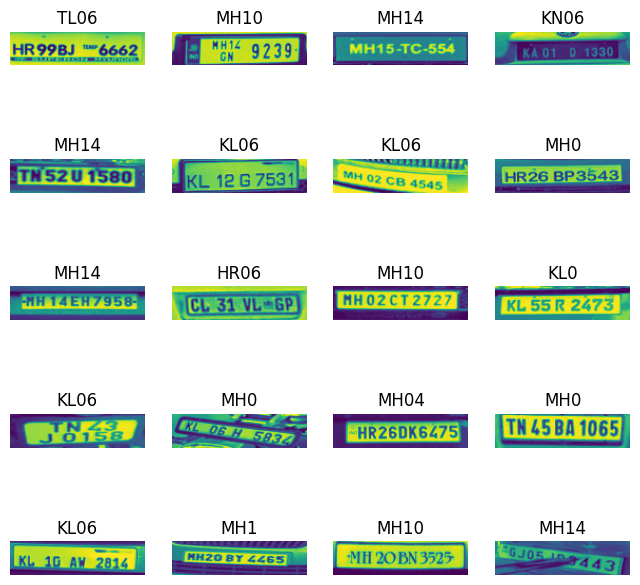

Character Accuracy: 17.04
plate Accuracy: 0.00
Precision: 0.00
Recall: 0.00
Predictions: ['HR06', 'P6', 'MH04', 'HN06', 'MH14', 'KL0', 'KN06', 'MH04', 'KL06', 'TN06', 'MH0', 'KH0', 'MH14', 'KL0', 'TL06', 'MH14', 'TN06', 'MH10', 'KL06', 'HN06', 'KL06', 'MH14', 'MH1', 'MH10', 'MH0', 'MH10', 'KH0', 'MH10', 'KL06', 'MH0', 'MH10', 'MH0', 'MH10', 'KL06', 'KH', 'MH14', 'MH14', 'KL06', 'HN06', 'HL06', 'MH14']
Targets: ['CL31VLGP', '46Z8892MH', 'KL48H9383', 'MH01A5R274', 'MH14EH7985', 'KL55R2473', 'KA01D0133', 'HR26DK6475', 'MH02CB4545', 'MH06A8929W', 'TN45BA1065', 'WB74X7605', 'GJ05443', 'KLT708253', 'HR99BJTEMP6662SUPERONHYUNDAI', 'MH03BS7778', 'MH14TCE4', 'MH14GN9239', 'KL12G7531', 'TN59AQ1515', 'KL10AWW814', 'TN52U1580', 'MH20B4Y546', 'KL10AV6342', 'KL06H5834', 'MH02CT2727', 'KA05HS4495', 'MH04EE2299', 'KL10AW2814', 'HR26BP3543', 'MH20DJ0419', 'KL10AV6633', 'MH2OBN3525', 'T0N2AH4432', 'DL49AK49', 'MH15TC554', 'WOBNP300', 'TN43J0158', 'KL02AF6363', 'HR26CT4063', 'WB07D5106']


In [179]:
# args['imgdir'] = 'images'
args['data'] = args['data_test']
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa, prec, rec, preds, targets = get_accuracy(args)
    print("Character Accuracy: %.2f\nplate Accuracy: %.2f"%(ca, wa))
    print("Precision: %.2f\nRecall: %.2f"%(prec, rec))
    print("Predictions:", preds)
    print("Targets:", targets)
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')


### Part 4

The model as is, is so bad and did not even give any predictions, in fact it has predicted blanks and that is due to several reasons. First, the data we are using is too small which does not allow the model to converge. Also the loss function we are using, CTC, if the number of epochs is low then there is a high propability to get blanks as we did in the first model. The images we are using are bad in my opinion and they are different from the images of the original task, they are more complicated for the model which requires bigger data for the model to be able to learn from it. These images have edges and have a noticeable level of noise. The number of epochs used in the original model is too small, with small data like this we need more epochs for a better chance of learning from the data.

![Original model accuracy](Car_plates_original_model.png)



### Part 5 and Bonus 1
I tried several architectures. I started by increasing the number of epochs and batch size with changing the learning rate. The best model I got was when using setting the number of epochs to 150 and the batch size to 128, with character accuracy of 14.54 but a word(plate number) accuracy of 0, still better than in the original model 'nan'. Changing the learning rate gave me worse models, either too slow or one that overfits.
![Second best model accuracy](second_best_model.png)


I then kept on trying to change the number of layers and their kind or even adding more layers (like adding non linearity to LSTM) or a dropout between the existing layers (although overfitting was not a real problem yet). Nothing really helped except for changing the number of layers to be 512. The character accuracy reached 17.04, while the word accuracy is still 0.

Adding more hidden layers allowed the model to learn more complex features and patterns in the data we are using.

With bigger and better data we might get a chance in enhancing such model to allow it to learn more effectively and generalize well. After all we all know what they say, <span style="color:red">*garbage in, garbage out*.</span>

I actually encountered an error when I tried changing the number of hidden layers in the beginning and that was due to the input size of the LSTM it was set to be: nHidden\*2 (256\*2=512) as the output size of CNN is 512, the input of the LSTM should also be 512, after changing it from 'nHidden' to 512 everything went smoothly.

For the precision and recall they were always 0 as expected.